In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import copy
import os as os

#from scipy.optimize import leastsq # Levenberg-Marquadt Algorithm
from scipy.optimize import curve_fit

In [30]:
# Data file 
sample_path='/data/visitors/nanomax/20190570/2019041008/process/as_deposited_2nd_indent_no_load/'
os.chdir(sample_path)
print(os.getcwd())
#print(os.listdir(sample_path))
extension='.h5'
for file in os.listdir(sample_path):
    if file.endswith(extension):
        print(os.path.join(file))


sample_file='scan_0000_pil1m_0000_integ_step.h5'
source=sample_path+sample_file

output_path=sample_path


/data/visitors/nanomax/20190570/2019041008/process/as_deposited_2nd_indent_no_load
scan_0000_pil1m_0000_integ_step.h5


In [146]:
# Class definition
class Read1DPilatusData:
    def __init__(self, data_input_file, output_path):
        
        # Store locals
        self.data_input_file = data_input_file
        # set output_path and remove trailing backslash
        self.output_path = os.path.normpath(output_path)
        
         # Separate file path from input file name
        self.filepath_input_file, self.filename = os.path.split(data_input_file)
        
         # Open the file and store number of data entries
        with h5py.File(self.data_input_file, 'r') as hf:
            self.data_keys = list(hf.keys())
            self.total_number_entries = len(self.data_keys)
        # Check that data file exist
        with h5py.File(self.data_input_file, 'r'):
            pass

    def data_read(self):
        
        with h5py.File(self.data_input_file,'r') as h5f:
            q_array = h5f["/entry/integ/q"][()]
            integration_array = h5f["/entry/integ/data"][()]
            sigma_array = h5f["/entry/integ/sigma"][()]
            azimuth_array =h5f[ "/entry/integ/azimuth_range"][()]
        
        return q_array, integration_array, sigma_array,azimuth_array 
    
    

class Fit1DPilatusData:
    def __init__(self, data_input_file, output_path):
        
        # Store locals
        self.data_input_file = data_input_file
        # set output_path and remove trailing backslash
        self.output_path = os.path.normpath(output_path)
        
        
        # Define fit parameters
        self.nbkg_params = 5 # number of bkg parameters
        
        # Create the data set
        reader = Read1DPilatusData(self.data_input_file, self.output_path)
        [q_array, integration_array, sigma_array,azimuth_array] = reader.data_read()
        self.q_array=q_array
        self.integration_array = integration_array
        self.sigma_array=sigma_array
        self.azimuth_array=azimuth_array
        
        # Verify the number of chis
        if (np.array_equal(self.q_array.shape[-1],self.integration_array.shape[-1]) and 
            np.array_equal(self.sigma_array.shape[-1],self.integration_array.shape[-1]) and 
            np.array_equal(self.sigma_array.shape[-1],self.azimuth_array.shape[-1])) is True:
            self.nchi= q_array.shape[-1]
            
    
    # model functions for diffraction line fitting
    def gaussian(self,x,p):
        y = np.log(2.) * ( (x - p[1])/(0.5*p[2]) )**2
        y = p[0]*np.exp(-y)
        y =  y * 2.*np.sqrt(np.log(2.)/np.pi)/p[2]
        return y

    def lorentzian(self,x,p):
        y = (x - p[1])/(0.5*p[2])
        y = p[0]/(1.+y**2)
        y =  y * 2./np.pi/p[2]
        return y

    # (multi-peak) pseudoVoigth function
    # parameters = [integI, position, fwhm, LorentzianContent]
    # one raw of output matrix per parameters line (one peak in each raw)
    # you can sum them by numpy.sum(pseudoVoigt(x,p),0)
    def pseudoVoigt(self,x,p):
        a = np.array(p)
        m = int(a.size / 4)
        a = a.reshape(m,4)
        y = np.zeros((m,len(x)),dtype=np.float)
        for k in range(0,m):
            if np.absolute(a[k,0])>0.:
                y[k] = (1.-a[k,3])*self.gaussian(x,a[k,0:3])+a[k,3]*self.lorentzian(x,a[k,0:3])
        return y

    
    # model - multiple pseudovoigt with quadratic background
    def model1(self,x,*p):
        y = np.sum(self.pseudoVoigt(x,p[0:-self.nbkg_params]),0)
        y = y + p[-5]/x + p[-4]*x**3 + p[-3]*x**2 + p[-2]*x + p[-1]
        return y

    def full_param_set(self,p,p0,l0):
        l0 = [item for sublist in l0 for item in sublist]
        lindp = np.array(l0)==1 # logical index
        pp = p0.copy()
        pp[lindp] = np.array(p)[()]
        return pp

    def curve_fit_wrap(self,model,x,y,p0,l0,sigma,absolute_sigma,bounds,maxfev):
        def _model(x,*p):
            pp = p0.copy()
            pp[lindp] = np.array(p)[()]
            y = model(x,*pp)
            return y
        l0 = [item for sublist in l0 for item in sublist]
        lindp = np.array(l0)==1 # logical index
        pp = p0[lindp] # eliminate parameters that we do not want to fit
        bounds = (np.asarray(bounds[0])[lindp].tolist(),np.asarray(bounds[1])[lindp].tolist())
        p1, pcov = curve_fit(_model,x,y,pp,sigma=sigma,absolute_sigma=absolute_sigma,bounds=bounds,maxfev=maxfev)
        return p1, pcov

    def build_bounds(self,p,qpos=np.inf,qrwidth=np.inf):
        p_min = []
        p_max = []
        # peak bounds
        for i in range(p.size-self.nbkg_params):
            pn = i % 4
            if (pn==0):
                # intensity
                p_min = p_min + [0.]
                p_max = p_max + [np.inf]
            elif (pn==1):
                # position
                p_min = p_min + [p[i]-qpos/2]
                p_max = p_max + [p[i]+qpos/2]
            elif (pn==2):
                # width
                p_min = p_min + [0.]
                p_max = p_max + [p[i]*qrwidth]
            elif (pn==3):
                # shape
                p_min = p_min + [0.]
                p_max = p_max + [1.]
            else:
                pass
        # background bounds
        # 1/x
        p_min = p_min + [0.]
        p_max = p_max + [np.inf]
        # polynomial
        for i in range(self.nbkg_params-1):
            p_min = p_min + [-np.inf]
            p_max = p_max + [np.inf]
        return (p_min,p_max)        
    
    # fitting
    def select_good_data(self,x,y):
        lidx = y>0
        #lidx = np.logical_and(lidx, np.logical_and(x>=2.4 , x<=2.8))
        #lidx = np.logical_and(lidx, np.logical_and(x>=4.0 , x<=5.0))
        # first good
        idx1 = np.where(lidx)[0][0]
        # last good
        idx2 = np.where(lidx)[0][-1]
        lidx = np.logical_and(lidx, np.logical_and(x>=x[idx1] , x<=x[idx2]))
        
        return x[lidx],y[lidx]

    def fitting(self,irow,ichi):
    # execute the fitting process
        #image number given as irow
        #irow=100  
        #azi_index, chi_index given as ichi
        #ichi=0
        
        # get chi range
        chi_range=self.azimuth_array[irow,:,ichi]
        
        # Select data
        xx, yy= self.select_good_data(self.q_array[irow,:,ichi],self.integration_array[irow,:,ichi])
        
        # Select the errors
        # Previous assumption, poissonian noise
        ss = np.sqrt(yy)
        # Using pyFAIs error model 'poisson', see above
        # That does not work currently
        
        # estimate background
        y0 = np.mean(yy[0:5])
        y1 = np.mean(yy[-5:])
        b1 = (y1-y0)/(xx[-1]-xx[0]) # slope
        b0 = y0 - b1*xx[0] # offset
        # initial parameters
        l0 = [[ 1, 0, 0, 0], # 2.506  1 1 1 0 small *111  TiAlN
              [ 1, 1, 1, 0], # 2.669  1 1 1 0 diffuse 111 TiAlN
              [ 1, 1, 1, 1], # 2.669  1 1 1 1 strong 111 TiAlN
              [ 1, 1, 1, 1], # 3.076  1 1 1 1 strong 200 TiAlN
              [ 1, 0, 0, 0], # 3.345  1 1 1 1 small *     TiAlN
              [ 1, 1, 1, 1], # 4.354  1 1 1 1 strong 220 TiAlN
              [ 1, 1, 1, 1], # 5.116  1 1 1 1 strong 311 TiAlN
              [ 1, 1, 1, 1], # 5.345  1 1 1 1 strong 222 TiAlN
              [ 1, 1, 1, 1], # 2.561  1 1 1 1 strong 111 TiN
              [ 1, 1, 1, 1], # 2.957  1 1 1 1 strong 200 TiN
              [1,1,1,1,1]]


        p0 = [[0.2, 2.506, 0.02, 0.0], # small *111 TiAlN
              [5.1, 2.669, 0.7, 1.0],   # diffuse 111 TiAlN
              [5.1, 2.669, 0.014, 0.3], # strong 111 TiAlN
              [1.4, 3.076, 0.050, 0.8], # strong 200 TiAlN
              [0.1, 3.345, 0.017, 0.0], # small * TiAlN
              [1.8, 4.363, 0.028, 0.4], # strong 220 TiAlN
              [0.6, 5.116, 0.040, 0.4], # strong 311 TiAlN
              [0.5, 5.345, 0.040, 0.4], # strong 222 TiAlN
              [2.161, 2.561, 0.01769, 0.183], # strong 111 TiN
              [5.4896, 2.957, 0.029269, 0.740]] # strong 200 TiN 
        
        npeaks = np.array(p0).shape[0]

        p0 = np.concatenate((np.array(p0).reshape(npeaks*4),[0.0,0.0,0.0,b1,b0]))
        bounds = self.build_bounds(p0,qpos=0.05,qrwidth=2.0)
        # fitting
        if (True):
            # --- the 1st fit stage ---
            # fix higher order bkg coeff
            _l0 = copy.deepcopy(l0)
            _l0[-1][-(self.nbkg_params-1):-2] = [0]*(self.nbkg_params-3)
            # fix all peak width and shape parameter and all positions
            for k in range(npeaks):
                _l0[k][1] = 0 # position
                _l0[k][2] = 0 # width
                _l0[k][3] = 0 # shape
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100)
            # return non-fitted parameters
            p0 = self.full_param_set(p1,p0,_l0)
            # --- the 2nd fit stage ---
            _l0 = copy.deepcopy(l0)
            # fix all peak width and shape parameter and all positions
            for k in range(npeaks):
                _l0[k][1] = 0 # position
                _l0[k][2] = 0 # width
                _l0[k][3] = 0 # shape
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100)
            # return non-fitted parameters
            p0 = self.full_param_set(p1,p0,_l0)
            # --- the 3rd fit stage ---
            _l0 = copy.deepcopy(l0)
            _p0 = copy.deepcopy(p0)
            # fix all peak parameters, outside of range
            for k in range(npeaks):
                if ((_p0[k*4+1]>=xx[-1]) or (_p0[k*4+1]<=xx[0])):
                    _l0[k][0] = 0 # intensity
                    _l0[k][1] = 0 # position
                    _l0[k][2] = 0 # width
                    _l0[k][3] = 0 # shape
                    _p0[k*4+0] = 0 # set intensity to zero
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,_p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=500)
            perr = np.sqrt(np.diag(pcov))
            # return non-fitted parameters
            p1 = self.full_param_set(p1,_p0,_l0)
            perr = self.full_param_set(perr,np.zeros(p1.shape),_l0)
            yyc = self.model1(xx,*p1)
        else:
            yyc = self.model1(xx,*p0) 
        # plot data
        font1=12
        
        plt.figure(figsize=(16, 4))
        plt.subplot(121)
        plt.plot(xx,yy,"*")
        plt.plot(xx,yyc,"-")
        plt.plot(xx,yyc-yy,"g-")
        plt.title('Fit, frame #: %d, azimuthal range (%d$\degree$, %d$\degree$), $\chi_{center}=$%d$\degree$"' 
                  %(irow, chi_range[0], chi_range[1], (chi_range[1]-chi_range[0])/2+chi_range[0]),fontdict={'fontsize': font1}) 
        plt.xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
        plt.ylabel('Intensity',fontdict={'fontsize':font1})
        plt.subplot(122)
        plt.semilogy(xx,yy,"*")
        plt.semilogy(xx,yyc,"-")
        plt.title('Fit, frame #: %d, azimuthal range (%d$\degree$, %d$\degree$), $\chi_{center}=$%d$\degree$"' 
                  %(irow, chi_range[0], chi_range[1], (chi_range[1]-chi_range[0])/2+chi_range[0]),fontdict={'fontsize': font1}) 
        plt.xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
        plt.ylabel('log(Intensity)',fontdict={'fontsize':font1})


        #plt.xlim((5.0,6.0))

        print( np.array(p1[:-self.nbkg_params]).reshape(npeaks,4) )
        print( p1[-self.nbkg_params:] )
    


    
    

class PeakPositions_TiAlN:
    def __init__(self, hkl_l=None, apar=None):
        
        if hkl_l is None:
            hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0]]
            Qhkl = np.zeros((len(hkl_l),))
        if apar is None:
            apar = 4.09 # (A)
        for k in range(len(hkl_l)):
            hkl = np.asarray(hkl_l[k])
            Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
            print("TiAlN %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))
    
        
class PeakPositions_TiN:
    def __init__(self, hkl_l=None,apar=None):
        
        if hkl_l is None:
            hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0]]
            Qhkl = np.zeros((len(hkl_l),))
        if apar is None:
            apar = 4.249 # (A) #Wikipedia   #Magnus: 4.2
        for k in range(len(hkl_l)):
            hkl = np.asarray(hkl_l[k])
            Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
            print("TiN %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))

PeakPositions_TiAlN()      
PeakPositions_TiN()
    

TiAlN 1 1 1    2.660830
TiAlN 2 0 0    3.072462
TiAlN 2 2 0    4.345118
TiAlN 3 1 1    5.095102
TiAlN 2 2 2    5.321661
TiAlN 4 0 0    6.144925
TiN 1 1 1    2.561261
TiN 2 0 0    2.957489
TiN 2 2 0    4.182521
TiN 3 1 1    4.904441
TiN 2 2 2    5.122521
TiN 4 0 0    5.914978


In [81]:
file1=Read1DPilatusData(source,output_path)

[q_array, integration_array, sigma_array,azimuth_array] = file1.data_read()

print(q_array.shape)
print(integration_array.shape)
print(sigma_array.shape)
print(azimuth_array.shape)

(5041, 1800, 9)
(5041, 1800, 9)
(5041, 1800, 9)
(5041, 2, 9)


In [143]:
fit1=Fit1DPilatusData(source,output_path)

In [145]:
nchi=1
fit1.fitting(0,nchi)
#fit1.fitting(1499,nchi)
#fit1.fitting(1500,nchi)
#fit1.fitting(1501,nchi)

#fit1.fitting(122,nchi)
#fit1.fitting(122,nchi)
#fit1.fitting(157,nchi)
#fit1.fitting(232,nchi)
#fit1.fitting(1012,nchi)
#fit1.fitting(2000,nchi)
#fit1.fitting(3000,nchi)
#fit1.fitting(3000,nchi)
#fit1.fitting(3500,nchi)
#fit1.fitting(4000,nchi)
#fit1.fitting(5000,nchi)

#fit1.fitting(10,nchi)
#fit1.fitting(50,nchi)
#fit1.fitting(100,nchi)
#fit1.fitting(100,nchi)
#fit1.fitting(200,nchi)
#fit1.fitting(300,nchi)
#fit1.fitting(400,nchi) #does not work
#fit1.fitting(500,nchi) #does not work
#fit1.fitting(800,nchi)
#fit1.fitting(1000,nchi)
#fit1.fitting(1499,nchi)
#fit1.fitting(1500,nchi)
#fit1.fitting(1501,nchi)
#fit1.fitting(1510,nchi)
#fit1.fitting(1520,nchi)
#fit1.fitting(1600,nchi)
#fit1.fitting(2000,nchi)
#fit1.fitting(3000,nchi)
#fit1.fitting(3500,nchi)
#fit1.fitting(4000,nchi)
#fit1.fitting(4500,nchi)
#fit1.fitting(5000,nchi)
#fit1.fitting(100,1)
#fit1.fitting(100,6)
#fit1.fitting(100,8)


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [134]:
# load data
a='fit_example.hdf5'    #0,270  #frame 2500
b='fit_example2.hdf5'   #0,45,135,225,270,315  #frame 3000


output_path='/data/visitors/nanomax/20190570/2019041008/process/as_deposited_2nd_indent_no_load/'

with h5py.File(output_path+b,'r') as h5f:
    q_array = h5f["/entry/integ/q"][()]
    integration_array = h5f["/entry/integ/intensity"][()]

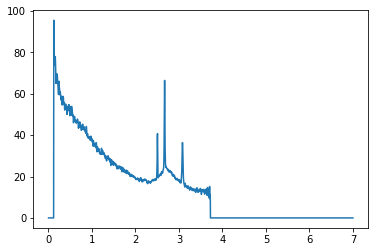

In [335]:
# plot data
irow = 1
plt.plot(q_array[irow,:],integration_array[irow,:])

(0, 4)

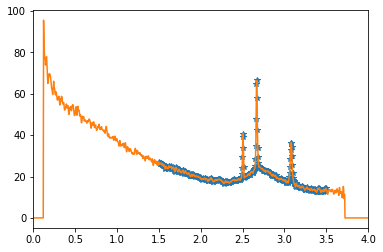

In [235]:
  def select_good_data(self,x,y):
        lidx = y>0
        lidx = np.logical_and(lidx, np.logical_and(x>=1.5 , x<=3.5))
        return x[lidx],y[lidx]

        x, y = select_good_data(q_array[irow,:],integration_array[irow,:])
        plt.plot(x,y,'*', q_array[irow,:],integration_array[irow,:],'-')
        plt.xlim((0,4))

[[4.83194930e-22 2.50600000e+00 2.00000000e-02 0.00000000e+00]
 [9.09460586e+00 2.69400000e+00 5.30311675e-01 1.00000000e+00]
 [9.40545652e-01 2.67587139e+00 2.03687129e-02 1.88188279e-01]
 [9.16702694e-02 3.08960891e+00 1.00000000e-01 1.00000000e+00]
 [2.89990477e-02 3.34500000e+00 1.70000000e-02 0.00000000e+00]
 [7.10276588e+00 4.35722125e+00 2.84416395e-02 2.85570397e-01]
 [0.00000000e+00 5.11600000e+00 4.00000000e-02 4.00000000e-01]
 [0.00000000e+00 5.34500000e+00 4.00000000e-02 4.00000000e-01]]
[  2.09756974  -0.84409273  10.03702705 -37.69073625  55.31534989]


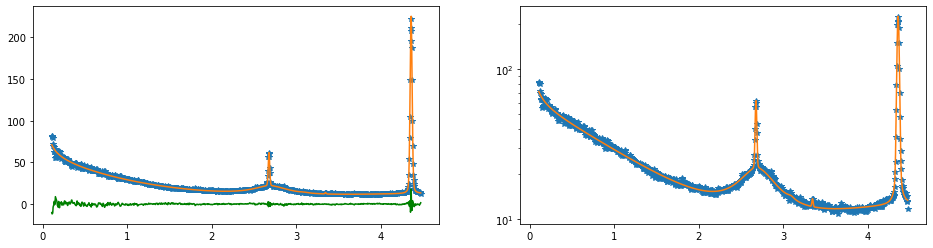

In [371]:
# fitting

def select_good_data(x,y):
    lidx = y>0
    #lidx = np.logical_and(lidx, np.logical_and(x>=2.4 , x<=2.8))
    #lidx = np.logical_and(lidx, np.logical_and(x>=4.0 , x<=5.0))
    # first good
    idx1 = np.where(lidx)[0][0]
    # last good
    idx2 = np.where(lidx)[0][-1]
    lidx = np.logical_and(lidx, np.logical_and(x>=x[idx1] , x<=x[idx2]))
    return x[lidx],y[lidx]

irow = 0

xx, yy = select_good_data(q_array[irow,:],integration_array[irow,:])
ss = np.sqrt(yy)

# estimate background
y0 = np.mean(yy[0:5])
y1 = np.mean(yy[-5:])
b1 = (y1-y0)/(xx[-1]-xx[0]) # slope
b0 = y0 - b1*xx[0] # offset
# initial parameters
l0 = [[ 1, 0, 0, 0], # 2.506  1 1 1 0 small *111
      [ 1, 1, 1, 0], # 2.669  1 1 1 0 diffuse 111
      [ 1, 1, 1, 1], # 2.669  1 1 1 1 strong 111
      [ 1, 1, 1, 1], # 3.076  1 1 1 1 strong 200
      [ 1, 0, 0, 0], # 3.345  1 1 1 1 small *    
      [ 1, 1, 1, 1], # 4.354  1 1 1 1 strong 220
      [ 1, 1, 1, 1], # 5.116  1 1 1 1 strong 311
      [ 1, 1, 1, 1], # 5.345  1 1 1 1 strong 222
      [1,1,1,1,1]]

p0 = [[0.2, 2.506, 0.02, 0.0], # small *111
      [5.1, 2.669, 0.7, 1.0],   # diffuse 111
      [5.1, 2.669, 0.014, 0.3], # strong 111
      [1.4, 3.076, 0.050, 0.8], # strong 200
      [0.1, 3.345, 0.017, 0.0], # small *
      [1.8, 4.363, 0.028, 0.4], # strong 220
      [0.6, 5.116, 0.040, 0.4], # strong 311
      [0.5, 5.345, 0.040, 0.4]] # strong 222

npeaks = np.array(p0).shape[0]

p0 = np.concatenate((np.array(p0).reshape(npeaks*4),[0.0,0.0,0.0,b1,b0]))
bounds = build_bounds(p0,qpos=0.05,qrwidth=2.0)
# fitting
if (True):
    # --- the 1st fit stage ---
    # fix higher order bkg coeff
    _l0 = copy.deepcopy(l0)
    _l0[-1][-(self.nbkg_params-1):-2] = [0]*(self.nbkg_params-3)
    # fix all peak width and shape parameter and all positions
    for k in range(npeaks):
        _l0[k][1] = 0 # position
        _l0[k][2] = 0 # width
        _l0[k][3] = 0 # shape
    p1, pcov = curve_fit_wrap(model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100)
    # return non-fitted parameters
    p0 = full_param_set(p1,p0,_l0)
    # --- the 2nd fit stage ---
    _l0 = copy.deepcopy(l0)
    # fix all peak width and shape parameter and all positions
    for k in range(npeaks):
        _l0[k][1] = 0 # position
        _l0[k][2] = 0 # width
        _l0[k][3] = 0 # shape
    p1, pcov = curve_fit_wrap(model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100)
    # return non-fitted parameters
    p0 = full_param_set(p1,p0,_l0)
    # --- the 3rd fit stage ---
    _l0 = copy.deepcopy(l0)
    _p0 = copy.deepcopy(p0)
    # fix all peak parameters, outside of range
    for k in range(npeaks):
        if ((_p0[k*4+1]>=xx[-1]) or (_p0[k*4+1]<=xx[0])):
            _l0[k][0] = 0 # intensity
            _l0[k][1] = 0 # position
            _l0[k][2] = 0 # width
            _l0[k][3] = 0 # shape
            _p0[k*4+0] = 0 # set intensity to zero
    p1, pcov = curve_fit_wrap(model1,xx,yy,_p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=500)
    perr = np.sqrt(np.diag(pcov))
    # return non-fitted parameters
    p1 = full_param_set(p1,_p0,_l0)
    perr = full_param_set(perr,np.zeros(p1.shape),_l0)
    yyc = model1(xx,*p1)
else:
    yyc = model1(xx,*p0) 
# plot data
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(xx,yy,"*")
plt.plot(xx,yyc,"-")
plt.plot(xx,yyc-yy,"g-")
plt.subplot(122)
plt.semilogy(xx,yy,"*")
plt.semilogy(xx,yyc,"-")

#plt.xlim((5.0,6.0))

print( np.array(p1[:-self.nbkg_params]).reshape(npeaks,4) )
print( p1[-self.nbkg_params:] )

In [359]:
print( np.array(perr[:-self.nbkg_params]).reshape(npeaks,4) )

[[5.31136898e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.93537840e-01 1.48922665e-02 7.32711213e-02 0.00000000e+00]
 [3.83799097e-01 4.13526592e-04 1.03741443e-03 2.28240379e-01]
 [2.41234970e-01 2.23593480e-04 5.97885047e-04 5.69410755e-02]
 [3.87836176e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.95382893e-01 1.40494498e-04 3.33301396e-04 2.97397803e-02]
 [1.44080128e-01 9.27142606e-04 2.89102817e-03 2.70150966e-01]
 [1.49985152e-01 7.02904866e-04 1.90117535e-03 2.27424259e-01]]


1 1 1    2.660830
2 0 0    3.072462
2 2 0    4.345118
3 1 1    5.095102
2 2 2    5.321661
4 0 0    6.144925
